In [1]:
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as stats

%load_ext autoreload
%autoreload 2

from housing_crawler.utils import save_file, get_file, crawl_ind_ad_page
from housing_crawler.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters

# Load data

In [2]:
ads_df = get_processed_ads_table()

===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


## Format dates properly

In [3]:
ads_df['published_on'] = pd.to_datetime(ads_df['published_on'], format = "%Y-%m-%d")
ads_df.shape

(25410, 146)

## Generate market type specific dataframes

In [4]:
typeoffer_ads_df = ads_df[['url', 'type_offer_simple']].groupby('type_offer_simple').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
typeoffer_ads_df

count
type_offer_simple       
WG                 15128
Apartment           5557
Single-room flat    4725

In [5]:
## Filter type of offer
wg_df = ads_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Analysis of features

## Histograms

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# SimpleImputer does not have get_feature_names_out, so we need to add it manually.
SimpleImputer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)

power_scaler = PowerTransformer(method = 'yeo-johnson')

In [7]:
## Try out if transformer is working
# PowerTrans_SimpImpMean_MinMaxScaler = Pipeline([
#     ('PowerTransformer', PowerTransformer()),
#     ('SimpleImputer', SimpleImputer(strategy="mean")),
#     ('MinMaxScaler', MinMaxScaler())
# ])

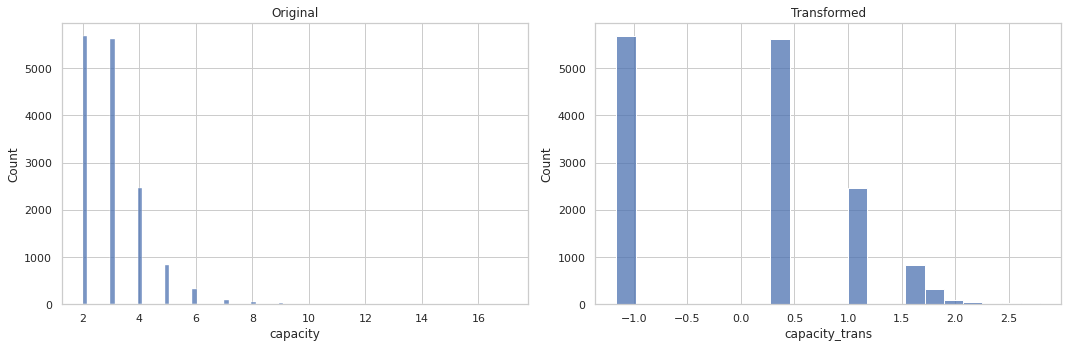

In [8]:
col_interest = 'capacity'
wg_df[col_interest +"_trans"] = power_scaler.fit_transform(wg_df[[col_interest]])

sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.histplot(data=wg_df, x = col_interest, kde=False, ax=ax1).set(title='Original')
sns.histplot(data=wg_df, x = col_interest +"_trans", kde=False, ax=ax2).set(title='Transformed')

plt.tight_layout();

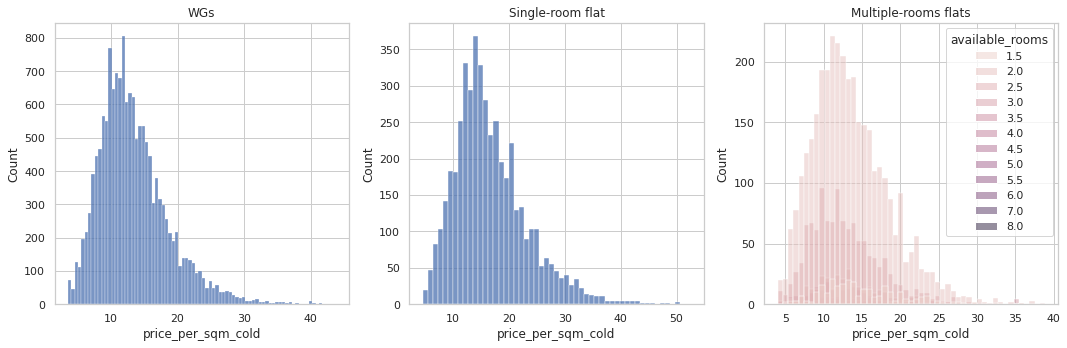

In [9]:
col_interest = 'price_per_sqm_cold'
wg_df[col_interest +"_trans"] = power_scaler.fit_transform(wg_df[[col_interest]])

sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(data=wg_df, x = col_interest, kde=False, ax=ax1).set(title='WGs')
sns.histplot(data=singleroom_df, x = col_interest, kde=False, ax=ax2).set(title='Single-room flat')
sns.histplot(data=flathouse_df, x = col_interest, kde=False, ax=ax3, hue = 'available_rooms').set(title='Multiple-rooms flats')

plt.tight_layout();

## Boxplot

''

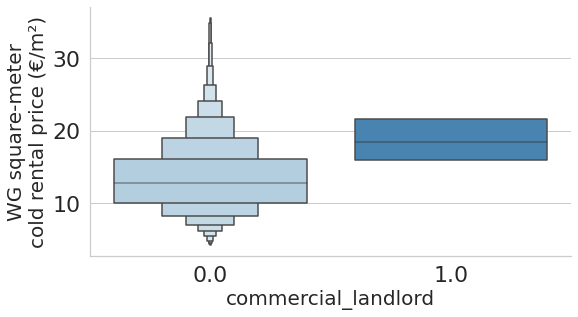

In [10]:
factor = 'commercial_landlord'
flathouse_df[factor] = flathouse_df[factor]#.astype(int)
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = flathouse_df, 
                 x = factor, y = 'price_per_sqm_cold',
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6, showfliers = False)
# ax.set(ylim=(0, 1600))
ax.set_ylabels(label="WG square-meter\ncold rental price (€/m²)", fontsize=20) # not set_label
ax.set_xlabels(fontsize=20) # not set_label
;

## Scatterplot

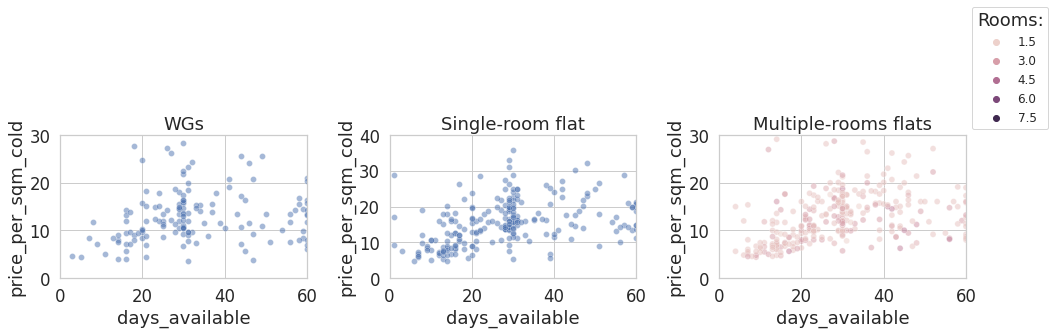

In [11]:
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data = wg_df.sample(1000), y='price_per_sqm_cold',x='days_available', ax=ax1, alpha=0.5).set(title='WGs')
sns.scatterplot(data = singleroom_df.sample(1000), y='price_per_sqm_cold',x='days_available', ax=ax2, alpha=0.5).set(title='Single-room flat')
sns.scatterplot(data = flathouse_df.sample(1000), y='price_per_sqm_cold',x='days_available', ax=ax3, alpha=0.5, hue = 'available_rooms').set(title='Multiple-rooms flats')
ax3.legend(title='Rooms:', fontsize=12, bbox_to_anchor= (1,1))# loc='upper right')

ax1.set_xlim(0, 60)
ax2.set_xlim(0, 60)
ax3.set_xlim(0, 60)

ax1.set_ylim(0, 30)
ax2.set_ylim(0, 40)
ax3.set_ylim(0, 30)

plt.tight_layout();

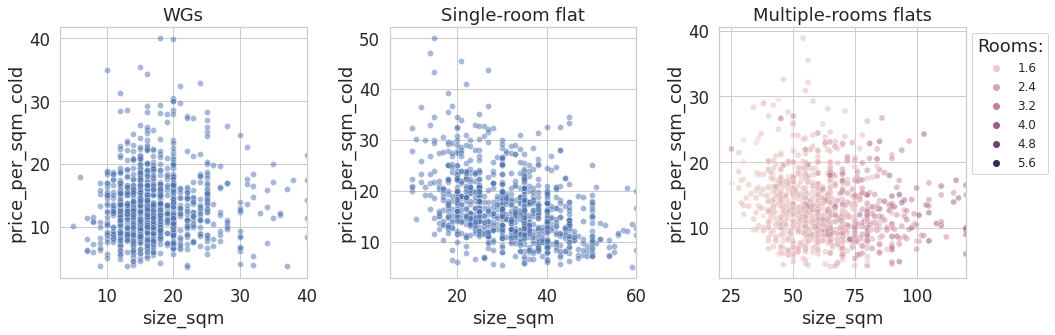

In [12]:
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data = wg_df.sample(1000), y='price_per_sqm_cold',x='size_sqm', alpha=0.5, ax=ax1).set(title='WGs')
sns.scatterplot(data = singleroom_df.sample(1000), y='price_per_sqm_cold',x='size_sqm', alpha=0.5, ax=ax2).set(title='Single-room flat')
sns.scatterplot(data = flathouse_df.sample(1000), y='price_per_sqm_cold',x='size_sqm', alpha=0.5, ax=ax3, hue = 'available_rooms').set(title='Multiple-rooms flats')
ax3.legend(title='Rooms:', fontsize=12, bbox_to_anchor= (1,1))# loc='upper right')

ax1.set_xlim(3, 40)
ax2.set_xlim(5, 60)
ax3.set_xlim(20, 120)

# ax1.set_ylim(0, 1000)
# ax2.set_ylim(0, 1500)
# ax3.set_ylim(0, 2000)

plt.tight_layout();

# Global picture of the data

In [13]:
typeoffer_ads_df = ads_df[['url', 'type_offer_simple', 'city']].groupby(['type_offer_simple', 'city']).count().rename(columns={'url':'count'}).reset_index().sort_values(by = ['type_offer_simple','count'], ascending=False)
typeoffer_ads_df.head(50)

type_offer_simple               city  count
51                WG             Berlin   2517
59                WG            Hamburg   1520
68                WG            München   1403
64                WG               Köln    989
72                WG          Stuttgart    962
65                WG            Leipzig    838
57                WG  Frankfurt am Main    728
60                WG           Hannover    556
55                WG            Dresden    533
69                WG            Münster    526
62                WG          Karlsruhe    525
50                WG             Aachen    469
53                WG             Bremen    365
66                WG              Mainz    339
61                WG         Heidelberg    311
56                WG         Düsseldorf    299
70                WG           Nürnberg    295
54                WG          Darmstadt    294
67                WG           Mannheim    282
74                WG           Würzburg    277
52                WG               Bonn    261
63                WG               Kiel    246
71                WG         Regensburg    246
58                WG          Göttingen    230
73                WG           Tübingen    117
26  Single-room flat             Berlin   1180
43  Single-room flat            München    578
39  Single-room flat               Köln    357
34  Single-room flat            Hamburg    264
32  Single-room flat  Frankfurt am Main    245
25  Single-room flat             Aachen    209
47  Single-room flat          Stuttgart    163
42  Single-room flat           Mannheim    149
31  Single-room flat         Düsseldorf    139
44  Single-room flat            Münster    136
36  Single-room flat         Heidelberg    129
27  Single-room flat               Bonn    123
41  Single-room flat              Mainz    110
40  Single-room flat            Leipzig    109
49  Single-room flat           Würzburg    101
30  Single-room flat            Dresden     97
46  Single-room flat         Regensburg     97
37  Single-room flat          Karlsruhe     96
45  Single-room flat           Nürnberg     92
35  Single-room flat           Hannover     80
28  Single-room flat             Bremen     67
29  Single-room flat          Darmstadt     62
33  Single-room flat          Göttingen     62
48  Single-room flat           Tübingen     52
38  Single-room flat               Kiel     28

## Temporal analysis of publications

In [14]:
dayweek_wg_df = wg_df[['url', 'day_of_week_publication']].groupby('day_of_week_publication').count().rename(columns={'url':'count'})
dayweek_wg_df['order'] = [5,1,6,7,4,2,3]
dayweek_wg_df = dayweek_wg_df.sort_values(by = ['order']).drop(['order'], axis=1)
dayweek_wg_df['Percentage'] = dayweek_wg_df['count'].apply(lambda x: round(100*x/sum(dayweek_wg_df['count']),2))
dayweek_wg_df

count  Percentage
day_of_week_publication                   
Mon                       2965       19.60
Tue                       2193       14.50
Wed                       2289       15.13
Thu                       2382       15.75
Fri                       1749       11.56
Sat                       1550       10.25
Sun                       2000       13.22

In [15]:
hourday_wg_df = wg_df[['url', 'published_at']].groupby('published_at').count().rename(columns={'url':'count'})
hourday_wg_df['Percentage'] = hourday_wg_df['count'].apply(lambda x: round(100*x/sum(hourday_wg_df['count']),2))
hourday_wg_df

count  Percentage
published_at                   
0               396        3.10
1               154        1.20
2                84        0.66
3                33        0.26
4                18        0.14
5                27        0.21
6                36        0.28
7               112        0.88
8               230        1.80
9               442        3.46
10              599        4.69
11              783        6.12
12              820        6.41
13              900        7.04
14              842        6.59
15              843        6.59
16              854        6.68
17              891        6.97
18              883        6.91
19              806        6.30
20              767        6.00
21              860        6.73
22              769        6.01
23              636        4.97

In [16]:
df_plot = ads_df[['url', 'city', 'published_on']].groupby(['published_on','city']).count().rename(columns={'url':'count'}).sort_values(by = ['published_on'], ascending=True).reset_index()
df_plot = df_plot[['count', 'city', 'published_on']].groupby(['published_on']).sum().rename(columns={'count':'mean'})
df_plot['mean'].mean()

498.2352941176471

''

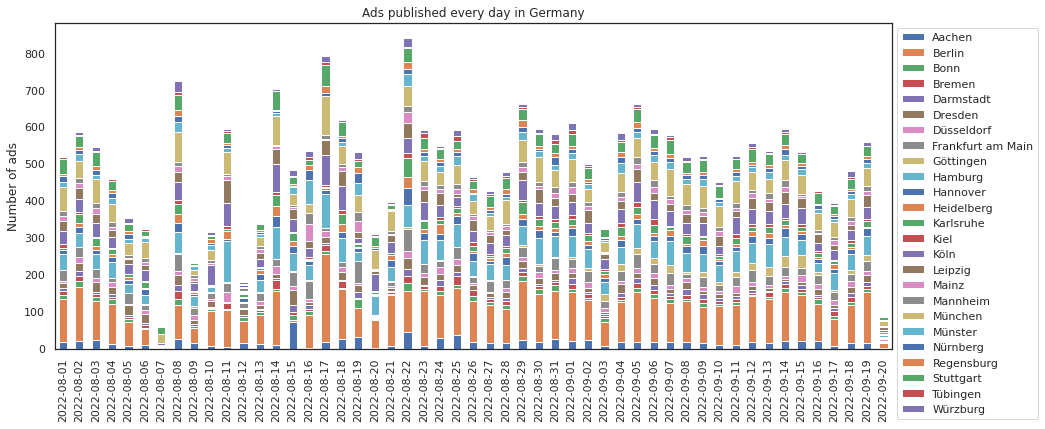

In [17]:
df_plot = ads_df[['url', 'city', 'published_on']].groupby(['published_on','city']).count().rename(columns={'url':'count'}).sort_values(by = ['published_on'], ascending=True).reset_index()
df_plot['published_on'] = df_plot['published_on'].dt.strftime('%Y-%m-%d')
df_plot = df_plot.pivot(index='published_on', columns='city', values='count')

sns.set_theme(style = "white", font_scale= 1)

fig = plt.figure(figsize=(15,6))
ax = plt.subplot(111)

df_plot.plot(kind='bar', stacked=True,ax=ax)
# labels for x & y axis
plt.xlabel(None)
plt.ylabel('Number of ads')
 
# title of plot
plt.title('Ads published every day in Germany')
plt.legend(bbox_to_anchor=(1, 1))
;

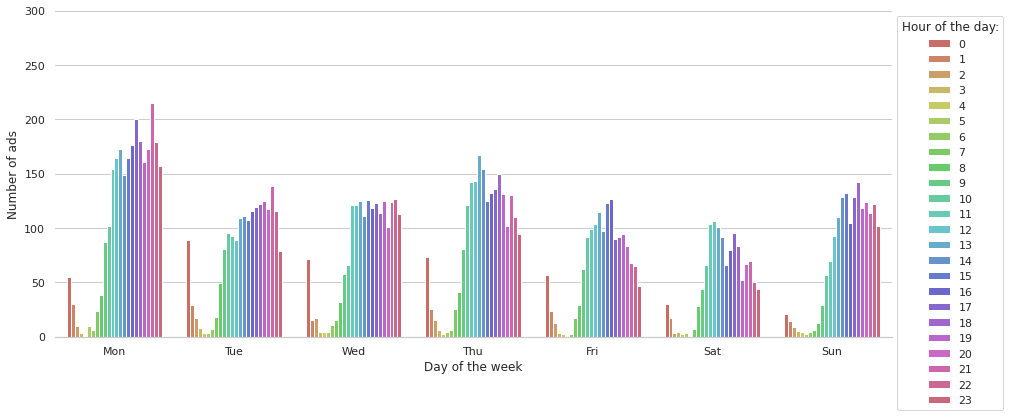

In [18]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax = plt.subplots(figsize=(15,6))

sns.countplot(
    data=wg_df[['day_of_week_publication','published_at']].dropna(axis=0),
    x="day_of_week_publication",
    hue = 'published_at',
    order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
    palette='hls', # or husl are exampels of circular color palletes
    ax=ax)
plt.legend(bbox_to_anchor = (1, 1), title = 'Hour of the day:')
sns.despine(top=True,left=True,right=True) # Background grid borders
ax.set(ylim=(0, 300), ylabel="Number of ads", xlabel="Day of the week");

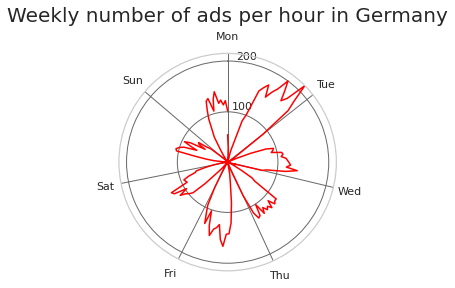

In [19]:
day_week_map = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
foo = wg_df.copy()
foo['day_week_number'] = foo['day_of_week_publication'].map(day_week_map)
foo = foo.sort_values(by = ['day_week_number'], ascending=True)
foo['week_hour_publication'] = foo['day_week_number']*24 + foo['published_at'] 
foo = foo[['url','week_hour_publication']].dropna(axis=0).groupby(['week_hour_publication']).count().rename(columns = {'url':'count'}).reset_index()



plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 361, 360/max(foo['week_hour_publication'])))]
mapping_dict = dict(zip(range(0,max([int(item) for item in foo['week_hour_publication']])+1), plotting_values))
foo['week_hour_publication_radians'] = foo['week_hour_publication'].map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')


foo.plot(x='week_hour_publication_radians', y='count', color ='red', ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values[::24])
ax.set_xticklabels(days_of_week)
ax.set_xlabel('')

ax.set_rmax(400)
ax.set_rticks([100,200,300])
ax.set_rlabel_position(5)  # Rotate labels

ax.get_legend().remove()
#change colors of axis to gray
ax.xaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)
ax.yaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)

ax.set_title("Weekly number of ads per hour in Germany", va='bottom', fontsize=20)
ax.margins(0)
plt.show()

In [20]:
wg_df_time = wg_df[['url', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).count().rename(columns = {'url':'count'}).reset_index()

plotting_values = [float(i) for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


fig = px.line_polar(wg_df_time, r="count", theta="published_at_radians", color="day_of_week_publication", line_close=True,
                    template="seaborn")
fig.show()

/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/plotly/

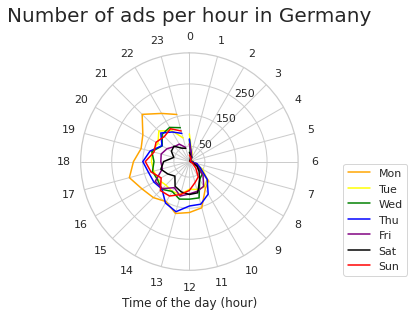

In [21]:
wg_df_time = wg_df[['url', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).count().rename(columns = {'url':'count'}).reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'count', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(350)
ax.set_rticks([50,150,250])
ax.set_rlabel_position(35)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Number of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

## Geographical analysis of data

In [22]:
city_wg_df = wg_df[['url', 'city']].groupby('city').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
city_wg_df['Percentage'] = city_wg_df['count'].apply(lambda x: round(100*x/sum(city_wg_df['count']),2))
city_wg_df

count  Percentage
city                                
Berlin              2517       16.64
Hamburg             1520       10.05
München             1403        9.27
Köln                 989        6.54
Stuttgart            962        6.36
Leipzig              838        5.54
Frankfurt am Main    728        4.81
Hannover             556        3.68
Dresden              533        3.52
Münster              526        3.48
Karlsruhe            525        3.47
Aachen               469        3.10
Bremen               365        2.41
Mainz                339        2.24
Heidelberg           311        2.06
Düsseldorf           299        1.98
Nürnberg             295        1.95
Darmstadt            294        1.94
Mannheim             282        1.86
Würzburg             277        1.83
Bonn                 261        1.73
Kiel                 246        1.63
Regensburg           246        1.63
Göttingen            230        1.52
Tübingen             117        0.77

In [23]:
city_ads_df = ads_df[['url', 'city',"type_offer_simple"]].groupby(['city',"type_offer_simple"]).count().rename(columns = {'url':'count'}).sort_values(by = ['count'], ascending=False).reset_index()
city_ads_df

city type_offer_simple  count
0      Berlin                WG   2517
1      Berlin         Apartment   1609
2     Hamburg                WG   1520
3     München                WG   1403
4      Berlin  Single-room flat   1180
..        ...               ...    ...
70  Darmstadt         Apartment     54
71   Tübingen  Single-room flat     52
72   Tübingen         Apartment     44
73       Kiel         Apartment     30
74       Kiel  Single-room flat     28

[75 rows x 3 columns]

In [24]:
city_ads_df = ads_df[['url', 'city',"type_offer_simple"]].groupby(['city',"type_offer_simple"]).count().rename(columns = {'url':'count'}).sort_values(by = ['count'], ascending=False).reset_index()
# reorderlist = list(city_ads_df.index)
# ads_df_ordered_counts = ads_df.iloc[pd.Categorical(ads_df.city,reorderlist).argsort()]

fig = px.bar(city_ads_df, x="city", y="count", color="type_offer_simple",
                    # title=' ',
            labels={
                "published_on": 'Make this label disappear',
                "count": 'Number of ads published per day',
                "city": "City"
            },
            template = "seaborn" #["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
            )
fig.show()

''

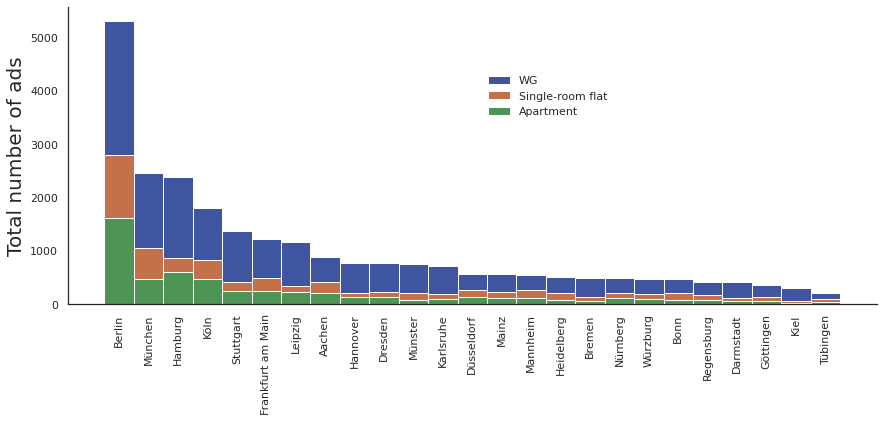

In [25]:
city_ads_df = ads_df[['url', 'city']].groupby('city').count().sort_values(by = ['url'], ascending=False)
reorderlist = list(city_ads_df.index)
ads_df_ordered_counts = ads_df.iloc[pd.Categorical(ads_df.city,reorderlist).argsort()]


sns.set_theme(style = "white", font_scale= 1)
ax = sns.displot(x='city', data=ads_df_ordered_counts, hue='type_offer_simple',
            hue_order=['WG', 'Single-room flat','Apartment'],
#             hue_labels=['WG', 'Single-room flat','Multi'],
            multiple='stack',
            height=5, aspect=10/4,
            palette='dark',
           )

# ax.set(ylim=(0, 8000));
ax.set_xticklabels(rotation = 90)
ax.set_ylabels(label="Total number of ads", fontsize=20)
ax.set_xlabels('', fontsize=20)

sns.move_legend(ax, loc = "upper right", bbox_to_anchor= (0.6,0.8), title = '')
;

## Price analysis

''

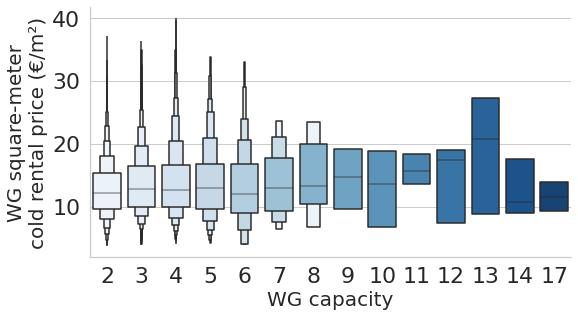

In [26]:
wg_df['capacity'] = wg_df['capacity'].astype(int)
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'capacity', y = 'price_per_sqm_cold',
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6, showfliers = False)
# ax.set(ylim=(0, 1600))
ax.set_ylabels(label="WG square-meter\ncold rental price (€/m²)", fontsize=20) # not set_label
ax.set_xlabels('WG capacity', fontsize=20) # not set_label
;

''

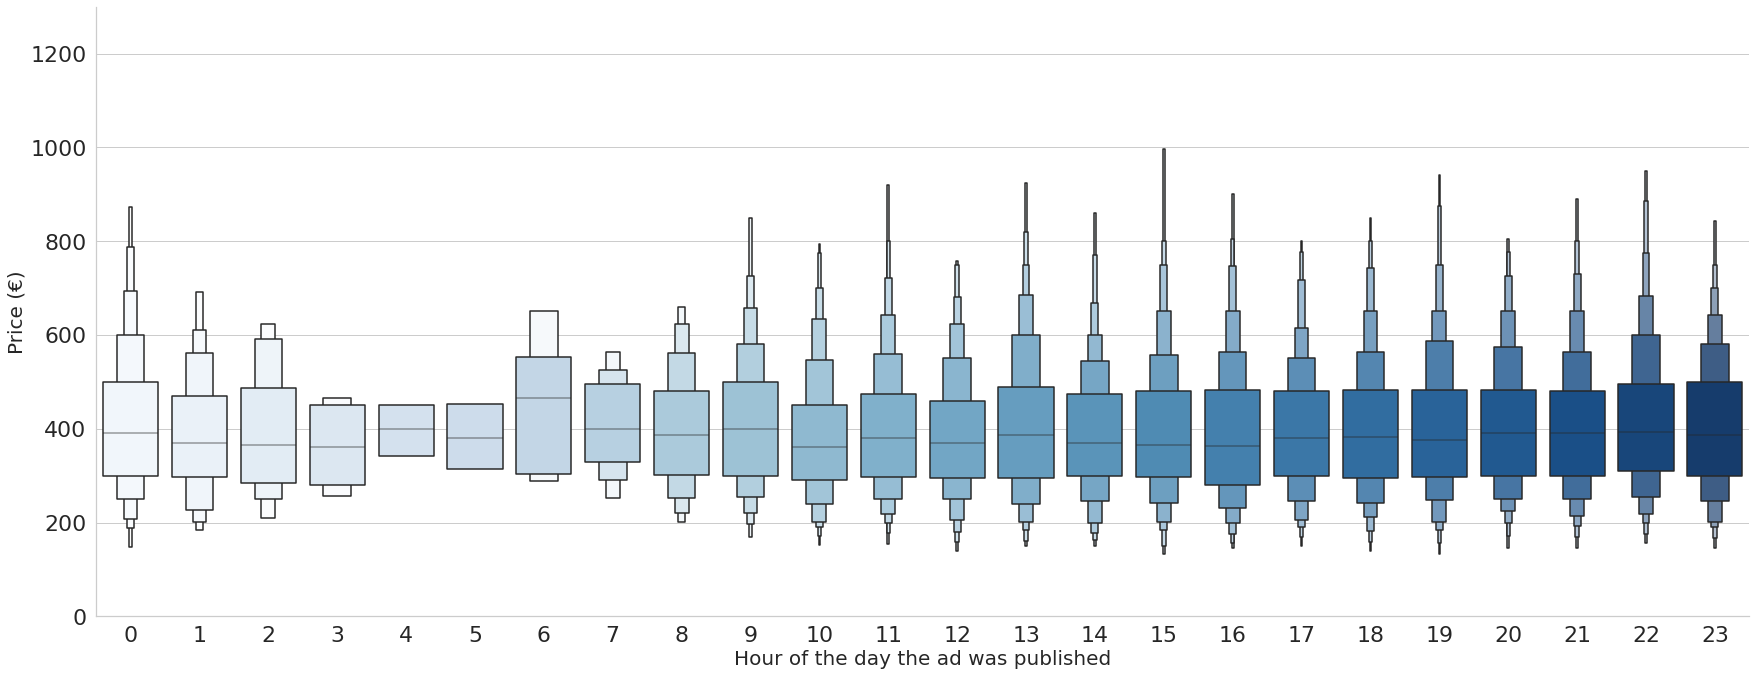

In [27]:
df_plot = wg_df[['published_at','cold_rent_euros']].dropna(axis=0)
df_plot['published_at'] = df_plot['published_at'].astype(int)
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = df_plot, 
                 x = 'published_at', y = 'cold_rent_euros',
                 kind='boxen',
                 palette='Blues',
                 height=10, aspect=10/4, showfliers = False)
ax.set(ylim=(0, 1300))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Hour of the day the ad was published', fontsize=20) # not set_label
;

''

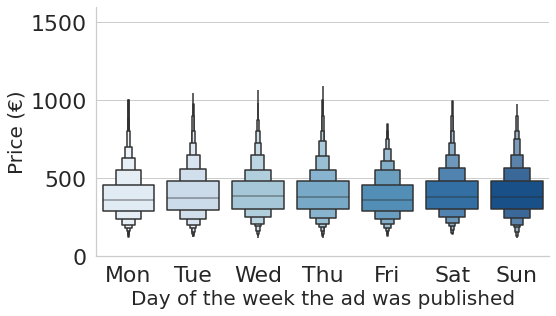

In [28]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'day_of_week_publication', y = 'cold_rent_euros',
                 order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6, showfliers = False)
ax.set(ylim=(0, 1600))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Day of the week the ad was published', fontsize=20) # not set_label
;

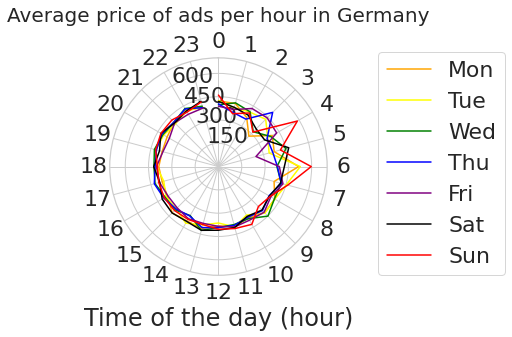

In [29]:
wg_df_time = wg_df[['cold_rent_euros', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).mean().reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


sns.set_theme(style = "whitegrid", font_scale= 2)
ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'cold_rent_euros', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(700)
ax.set_rticks([150,300,450,600])  # Move radial labels away from plotted line
ax.set_rlabel_position(-30)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Average price of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

# Ranking cities

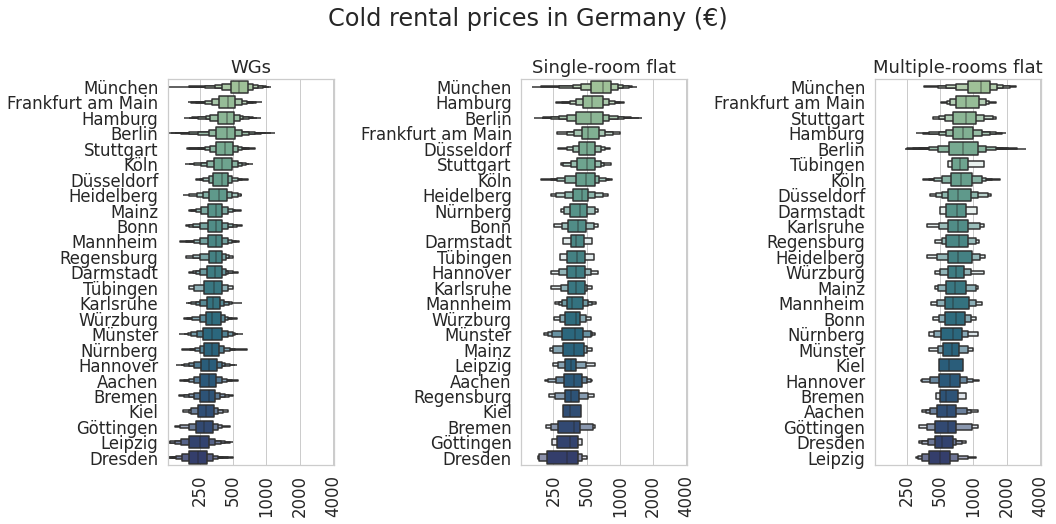

In [30]:
# Log transform prices
wg_df_mod = wg_df.copy()
wg_df_mod['cold_rent_euros'] = np.log2(wg_df_mod['cold_rent_euros'])

singleroom_df_mod = singleroom_df.copy()
singleroom_df_mod['cold_rent_euros'] = np.log2(singleroom_df_mod['cold_rent_euros'])

flathouse_df_mod = flathouse_df.copy()
flathouse_df_mod['cold_rent_euros'] = np.log2(flathouse_df_mod['cold_rent_euros'])

# Finding the order
city_wg_df = wg_df_mod[['cold_rent_euros', 'city']].groupby('city').mean().sort_values(by = ['cold_rent_euros'], ascending=False)
city_singleroom_df = singleroom_df_mod[['cold_rent_euros', 'city']].groupby('city').mean().sort_values(by = ['cold_rent_euros'], ascending=False)
city_flathouse_df = flathouse_df_mod[['cold_rent_euros', 'city']].groupby('city').mean().sort_values(by = ['cold_rent_euros'], ascending=False)


# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df_mod, y = 'city', x = 'cold_rent_euros',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WGs')

sns.boxenplot(data = singleroom_df_mod, y = 'city', x = 'cold_rent_euros',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df_mod, y = 'city', x = 'cold_rent_euros',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax1.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax1.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])


ax2.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax2.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax2.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])

ax3.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax3.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax3.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])
fig.suptitle('Cold rental prices in Germany (€)', fontsize=24)

plt.tight_layout();

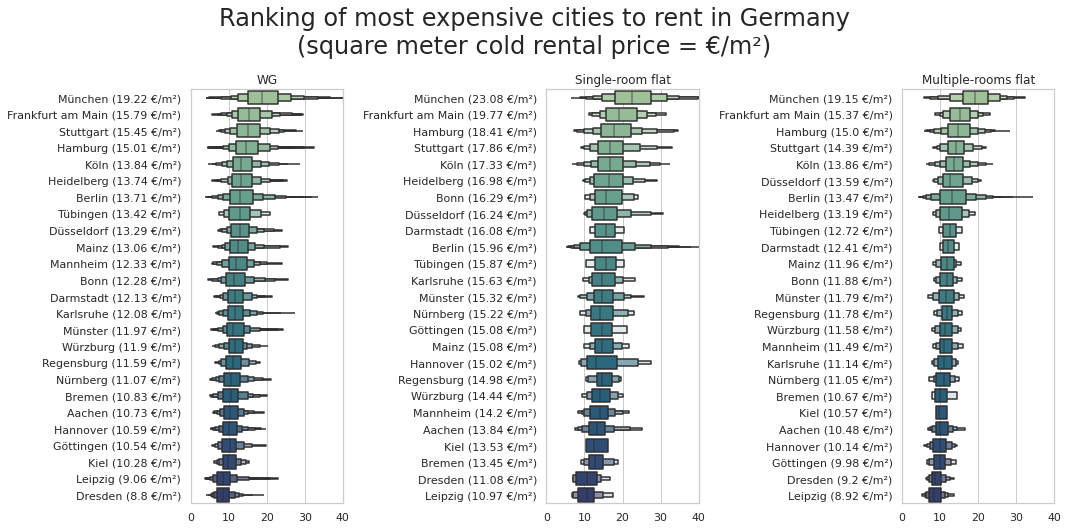

In [31]:
# Finding the order
city_wg_df = wg_df[['price_per_sqm_cold', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm_cold'], ascending=False)
city_singleroom_df = singleroom_df[['price_per_sqm_cold', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm_cold'], ascending=False)
city_flathouse_df = flathouse_df[['price_per_sqm_cold', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm_cold'], ascending=False)

# Log transform prices
# wg_df_mod = wg_df.copy()
# wg_df_mod['price_per_sqm_cold'] = np.log2(wg_df_mod['price_per_sqm_cold'])

# singleroom_df_mod = singleroom_df.copy()
# singleroom_df_mod['price_per_sqm_cold'] = np.log2(singleroom_df_mod['price_per_sqm_cold'])

# flathouse_df_mod = flathouse_df.copy()
# flathouse_df_mod['price_per_sqm_cold'] = np.log2(flathouse_df_mod['price_per_sqm_cold'])

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df, y = 'city', x = 'price_per_sqm_cold',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WG')

sns.boxenplot(data = singleroom_df, y = 'city', x = 'price_per_sqm_cold',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df, y = 'city', x = 'price_per_sqm_cold',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(0, 40), xlabel=None, ylabel=None)
ax1.set_xticks(range(0,41,10))
name_city_price = []

for city in city_wg_df.index:
    name_city_price.append(f'{city} ({round(city_wg_df.loc[city]["price_per_sqm_cold"],2)} €/m²)')
ax1.set_yticks(range(0,25), name_city_price)



ax2.set(xlim=(0, 40), xlabel=None, ylabel=None)
ax2.set_xticks(range(0,41,10))

name_city_price = []
for city in city_singleroom_df.index:
    name_city_price.append(f'{city} ({round(city_singleroom_df.loc[city]["price_per_sqm_cold"],2)} €/m²)')
ax2.set_yticks(range(0,25), name_city_price)



ax3.set(xlim=(0, 40), xlabel=None, ylabel=None)
ax3.set_xticks(range(0,41,10))

name_city_price = []
for city in city_flathouse_df.index:
    name_city_price.append(f'{city} ({round(city_flathouse_df.loc[city]["price_per_sqm_cold"],2)} €/m²)')
ax3.set_yticks(range(0,25), name_city_price)



fig.suptitle('Ranking of most expensive cities to rent in Germany\n(square meter cold rental price = €/m²)', fontsize=24)

plt.tight_layout();

In [32]:
def create_ridgeline_plot(df = wg_df,
                          column = 'cold_rent_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG rent in Germany,\n rent (€)', unit='€'):
    
    foo_df = df[[column, factor]].groupby(by=factor).mean().sort_values(by = column, ascending=False).reset_index().copy()
    ordered_factors = foo_df[factor].tolist()
    mapping_dict = dict(zip(ordered_factors, range(1,len(ordered_factors)+1,1)))
    # Map city order for plotting
    df['order_factors'] = df[factor].map(mapping_dict)

    # Limit prices for the plot
    df = df[df[column] <= max_x]
    df = df[df[column] >= min_x]

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})  

    # we generate a color palette with Seaborn.color_palette()
    pal = sns.color_palette(palette=pal_name, n_colors=len(ordered_factors))  

    # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
    g = sns.FacetGrid(df, row='order_factors', hue='order_factors', aspect=10, height=1, palette=pal)

    # then we add the densities kdeplots for each city
    g.map(sns.kdeplot, column,
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)

    # here we add a white line that represents the contour of each kdeplot
    g.map(sns.kdeplot, column, 
          bw_adjust=1, clip_on=False, 
          color="w", lw=3)

    # here we add a horizontal line for each plot
    g.map(plt.axhline, y=0,
          lw=0.25, clip_on=False)

    # we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
    # notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
    for i, ax in enumerate(g.axes.flat):
        factor_name = list(mapping_dict.keys())[i]
        mean_value = round(float(foo_df[foo_df[factor] == factor_name][column]),2)
        
        ax.text(-(max_x+abs(min_x))/5, max_y/10, # Text location
                f'{factor_name}\nmean = {mean_value} {unit}', # Text label
                fontsize=15,
                color=ax.lines[-1].get_color()) # Text color

    # we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.75)

    # eventually we remove axes titles, yticks and spines
    g.set_titles("")
    g.set(ylabel = '', yticks=[], ylim = (min_y,max_y), xlim = (-(max_x+abs(min_x))/5, max_x))
    g.despine(bottom=True, left=True)

    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('')
    g.fig.suptitle(title,
                   ha='center',
                   fontsize=20,
                   fontweight=20);
    
    return g

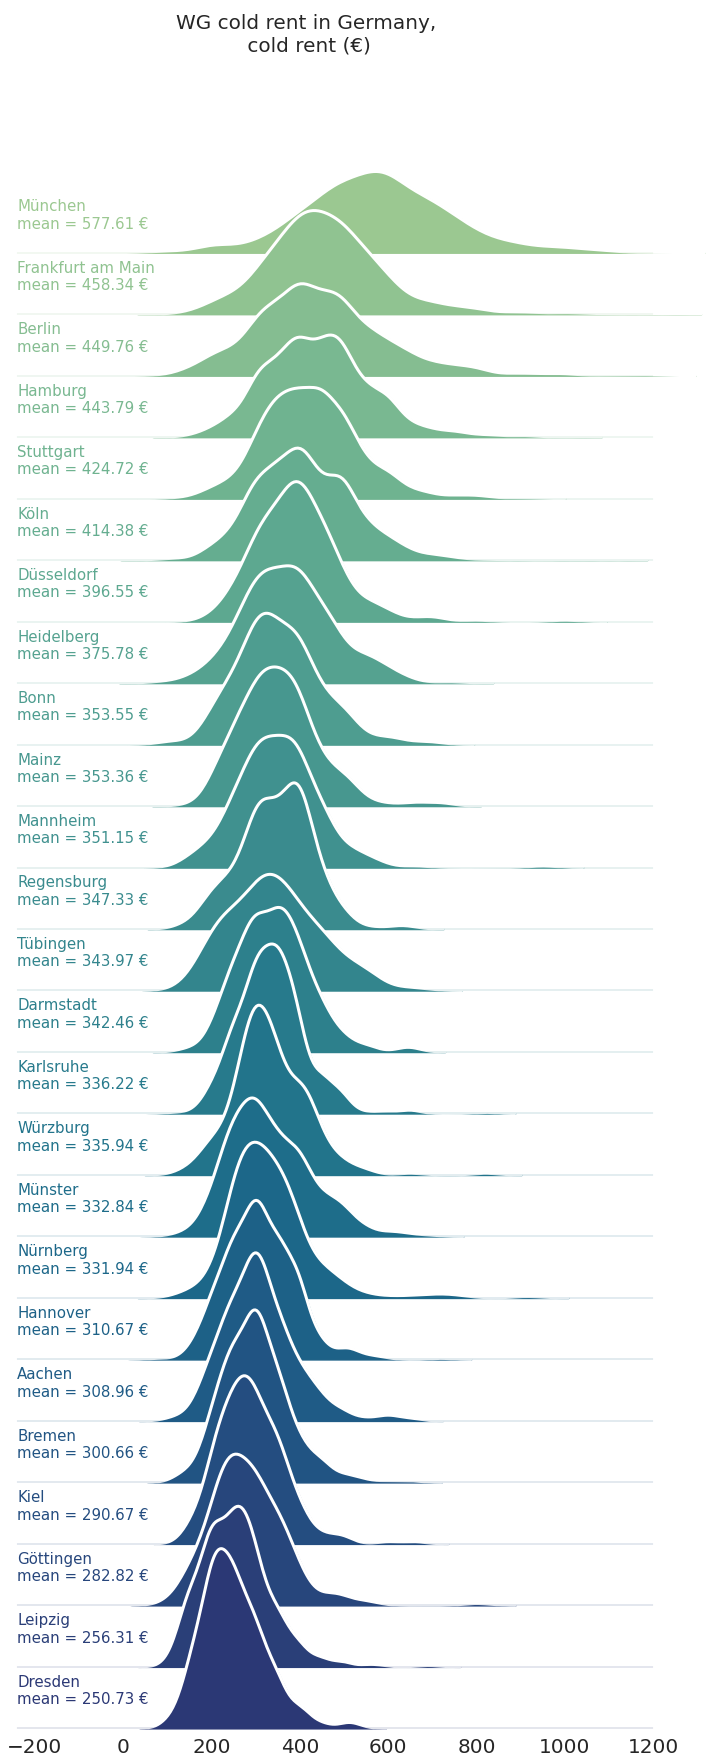

In [33]:
create_ridgeline_plot(df = wg_df,
                          column = 'cold_rent_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG cold rent in Germany,\n cold rent (€)');

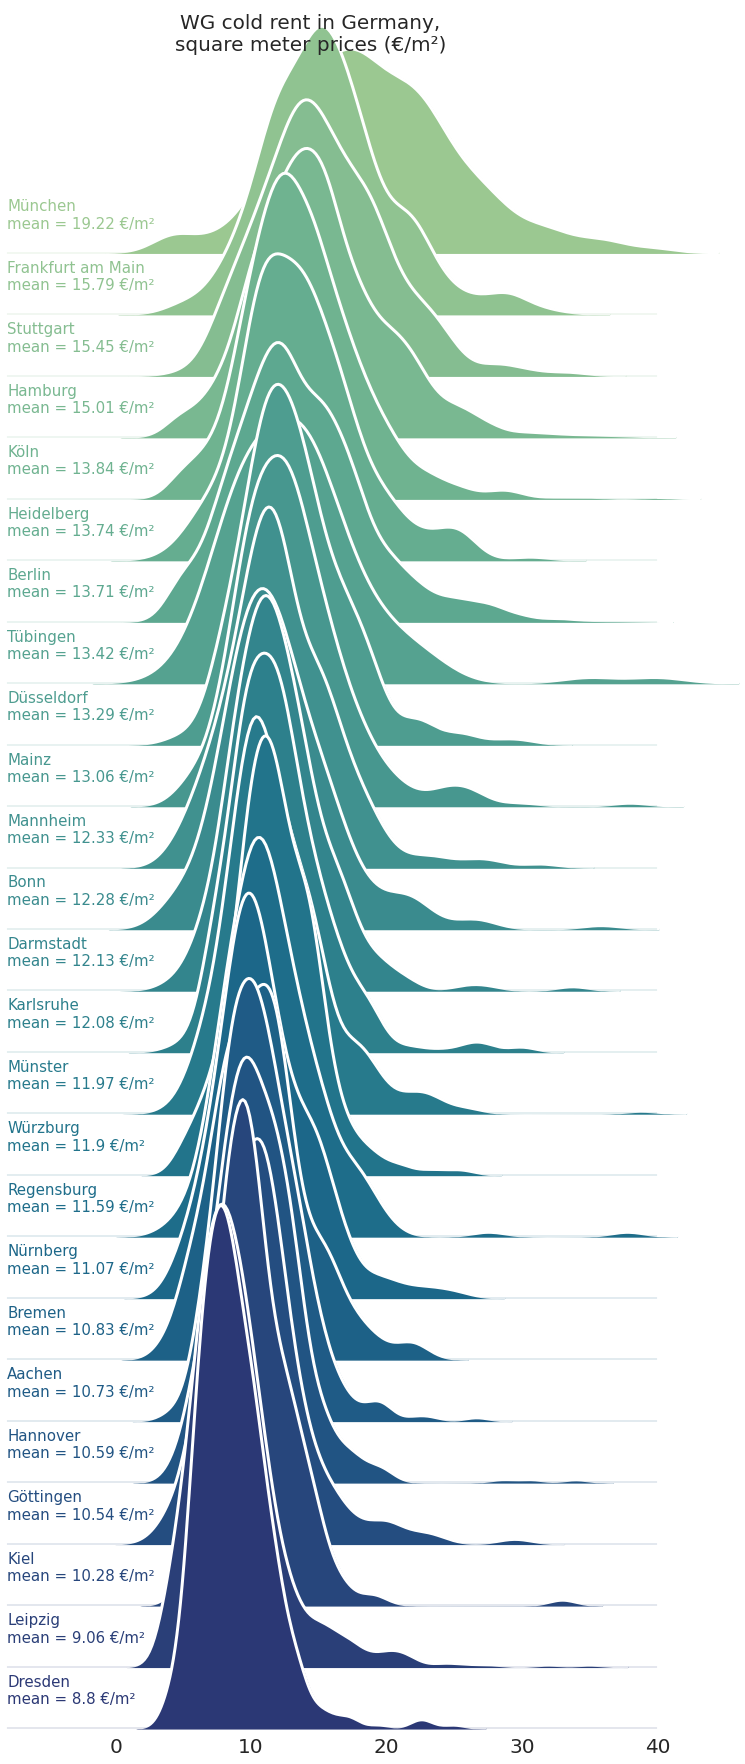

In [34]:
create_ridgeline_plot(df = wg_df,
                          column = 'price_per_sqm_cold',
                          factor = 'city',
                          max_x = 40, min_x = 0,
                          max_y = 0.08, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG cold rent in Germany,\nsquare meter prices (€/m²)', unit = '€/m²');

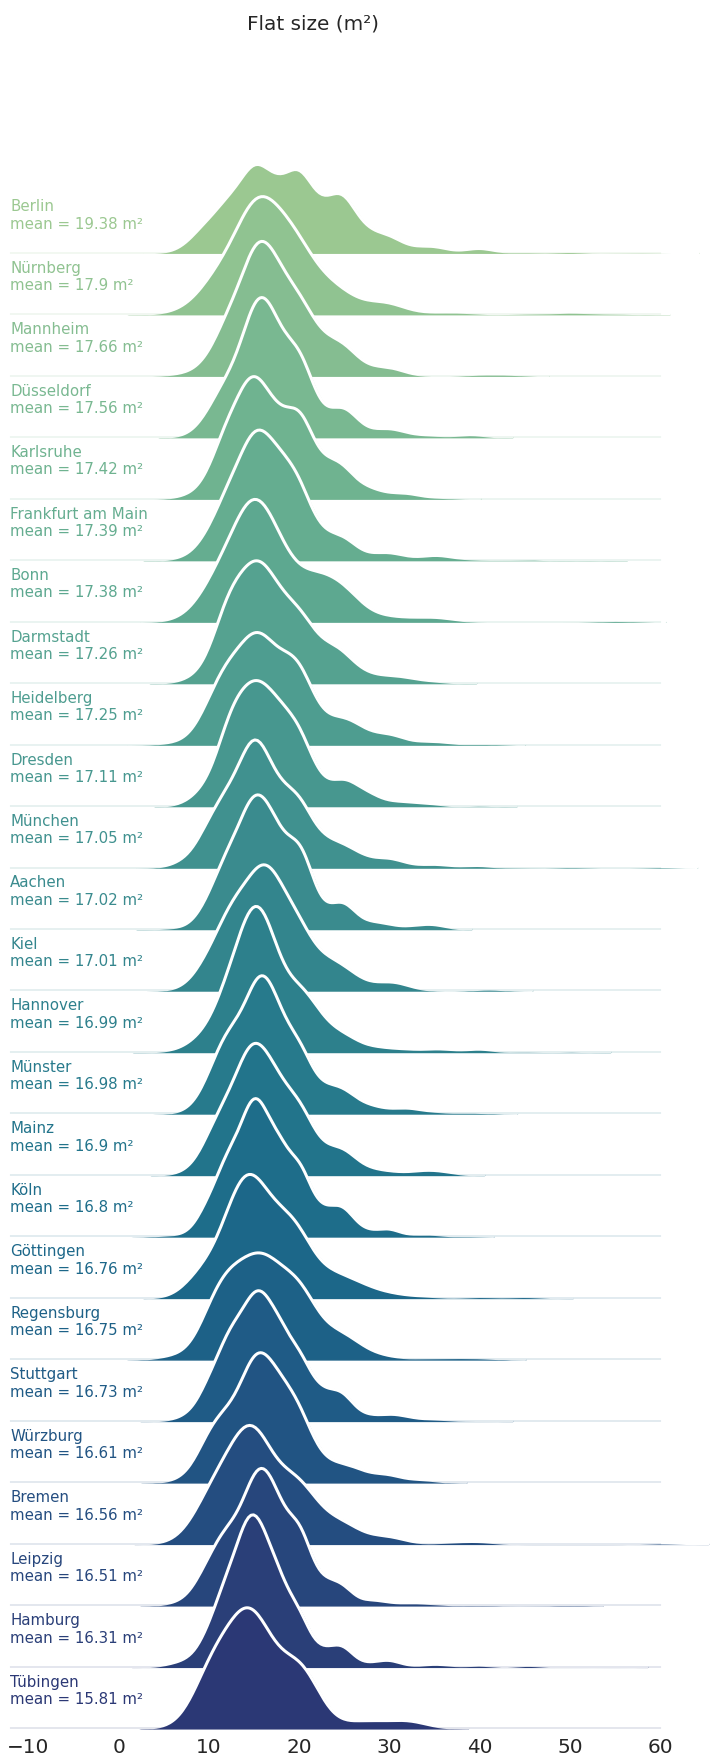

In [35]:
create_ridgeline_plot(df = wg_df,
                          column = 'size_sqm',
                          factor = 'city',
                          max_x = 60, min_x = 0,
                          max_y = 0.182, min_y = 0,
                          pal_name = 'crest',
                         title = 'Flat size (m²)', unit = 'm²');

sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)

# Comparing WG, single-room and multi-room flats

In [36]:
# Generate tables for plotting
ads_df_grouped = ads_df[['price_per_sqm_cold', 'city', 'type_offer_simple']].groupby(['city','type_offer_simple']).mean().reset_index()
ads_df_grouped = ads_df_grouped.pivot(index='city', columns = 'type_offer_simple', values='price_per_sqm_cold').reset_index()

from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3)#,
#     subplot_titles=("WG X multi-room flat", "WG X Single-room flat", "multi-room flat X Single-room flat"))

ax1= px.scatter(data_frame = ads_df_grouped, y='Apartment',x='WG', color = 'city')
for index in range(len(ax1['data'])):
    fig.add_trace(ax1['data'][index],
                  row=1, col=1)

ax2= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='WG', color = 'city')
for index in range(len(ax2['data'])):
    fig.add_trace(ax2['data'][index],
                  row=1, col=2)

ax3= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='Apartment', color = 'city')
for index in range(len(ax3['data'])):
    fig.add_trace(ax3['data'][index],
                  row=1, col=3)

fig.update_layout(height=400, width=1000,
                  title_text="Average square-meter prices in Germany (€/m²)", showlegend=False)

# Update xaxis properties
fig.update_xaxes(title_text="WGs", #range=[15, 45],
                 row=1, col=1)
fig.update_xaxes(title_text="WGs", #range=[15, 45],
                 row=1, col=2)
fig.update_xaxes(title_text="Multi-room flats", #range=[10, 25], 
                 row=1, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Multi-room flats", #range=[10, 25],
                 row=1, col=1)
fig.update_yaxes(title_text="Single-room flats", #range=[10, 35],
                 row=1, col=2)
fig.update_yaxes(title_text="Single-room flats", #range=[10, 35],
                 row=1, col=3)


fig.show()

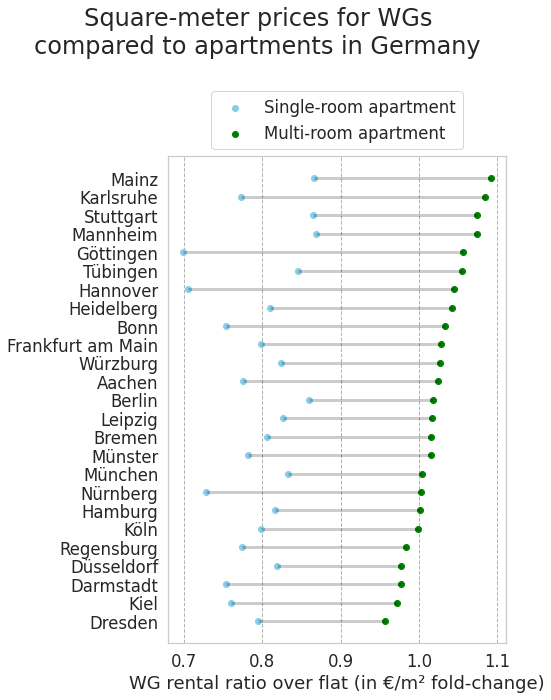

In [37]:
# Finding the order
ads_df_grouped = ads_df[['price_per_sqm_cold', 'city', 'type_offer_simple']].groupby(['city','type_offer_simple']).mean().reset_index()
ads_df_grouped = ads_df_grouped.pivot(index='city', columns = 'type_offer_simple', values='price_per_sqm_cold').reset_index()
ads_df_grouped['WGxApartment_ratio'] = ads_df_grouped['WG']/ads_df_grouped['Apartment']
# ads_df_grouped['WGxHouse_ratio'] = ads_df_grouped['WG']/ads_df_grouped['House']
ads_df_grouped['WGxSingleroomflat_ratio'] = ads_df_grouped['WG']/ads_df_grouped['Single-room flat']
ads_df_grouped['ApartmentxSingleroomflat_ratio'] = ads_df_grouped['Apartment']/ads_df_grouped['Single-room flat']

# Reorder it following the values of the first value:
ordered_df = ads_df_grouped.sort_values(by = ['WGxApartment_ratio'], ascending=True).copy()
my_range=range(1,len(ordered_df)+1)

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 10))


# The horizontal plot is made using the hline function
ax1.hlines(y=my_range, xmin=ordered_df['WGxSingleroomflat_ratio'], xmax=ordered_df['WGxApartment_ratio'], color='black', alpha=0.2, linewidth = 3)
ax1.scatter(ordered_df['WGxSingleroomflat_ratio'], my_range, color='skyblue', alpha=1, label='Single-room apartment')
ax1.scatter(ordered_df['WGxApartment_ratio'], my_range, color='green', alpha=1 , label='Multi-room apartment')
ax1.legend()
 
# Add title and axis names
ax1.set(title=None, #xlim=(1, 2),
        xlabel='WG rental ratio over flat (in €/m² fold-change)', ylabel=None)
ax1.set_yticks(my_range, ordered_df['city'])

ax1.legend(loc="upper center", bbox_to_anchor=(.5,1.15))

ax1.yaxis.grid(False)#,color='dimgray', linestyle='--', linewidth = 1)
ax1.xaxis.grid(True,color='dimgray', linestyle='--', linewidth = 1, alpha=0.5)



fig.suptitle('Square-meter prices for WGs\ncompared to apartments in Germany', fontsize=24)


# Show the graph
plt.tight_layout()
plt.show();

# Map of zip codes price

In [38]:
# This part of the code was adapted from: https://juanitorduz.github.io/germany_plots/
import geopandas as gpd
from config.config import ROOT_DIR

In [39]:
plz_shape_df = gpd.read_file(f'{ROOT_DIR}/housing_crawler/data/germany/plz-5stellig/plz-5stellig.shp', dtype={'plz': str})
# Create feature.
plz_shape_df.head()

plz           note        qkm  einwohner  \
0  01067  01067 Dresden   6.866862      11957   
1  01069  01069 Dresden   5.351833      25491   
2  01097  01097 Dresden   3.297752      14821   
3  01099  01099 Dresden  58.506789      28018   
4  01108  01108 Dresden  16.447222       5876   

                                            geometry  
0  POLYGON ((13.68689 51.06395, 13.69570 51.06499...  
1  MULTIPOLYGON (((13.72009 51.04664, 13.72248 51...  
2  POLYGON ((13.72548 51.06860, 13.72629 51.06900...  
3  POLYGON ((13.74218 51.08979, 13.74335 51.08863...  
4  POLYGON ((13.76543 51.17491, 13.76637 51.17469...

In [40]:
plz_region_df = pd.read_csv(f'{ROOT_DIR}/housing_crawler/data/germany/zuordnung_plz_ort.csv', 
    sep=',', 
    dtype={'plz': str}
)

plz_region_df.drop('osm_id', axis=1, inplace=True)

plz_region_df.head()

ags     ort    plz                 landkreis           bundesland
0  8335001    Aach  78267        Landkreis Konstanz    Baden-Württemberg
1  7235001    Aach  54298  Landkreis Trier-Saarburg      Rheinland-Pfalz
2  5334002  Aachen  52062       Städteregion Aachen  Nordrhein-Westfalen
3  5334002  Aachen  52064       Städteregion Aachen  Nordrhein-Westfalen
4  5334002  Aachen  52066       Städteregion Aachen  Nordrhein-Westfalen

In [41]:
# Merge data.
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

germany_df.head()

plz        qkm  einwohner  \
0  01067   6.866862      11957   
1  01069   5.351833      25491   
2  01097   3.297752      14821   
3  01099  58.506789      28018   
4  01108  16.447222       5876   

                                            geometry       ags      ort  \
0  POLYGON ((13.68689 51.06395, 13.69570 51.06499...  14612000  Dresden   
1  MULTIPOLYGON (((13.72009 51.04664, 13.72248 51...  14612000  Dresden   
2  POLYGON ((13.72548 51.06860, 13.72629 51.06900...  14612000  Dresden   
3  POLYGON ((13.74218 51.08979, 13.74335 51.08863...  14612000  Dresden   
4  POLYGON ((13.76543 51.17491, 13.76637 51.17469...  14612000  Dresden   

  landkreis bundesland  
0       NaN    Sachsen  
1       NaN    Sachsen  
2       NaN    Sachsen  
3       NaN    Sachsen  
4       NaN    Sachsen

In [42]:
plz_einwohner_df = pd.read_csv(
    f'{ROOT_DIR}/housing_crawler/data/germany/plz_einwohner.csv', 
    sep=',', 
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

plz           note  einwohner        qkm       lat       lon
0  01067  01067 Dresden      11957   6.866862  51.06019  13.71117
1  01069  01069 Dresden      25491   5.351816  51.03964  13.73030
2  01097  01097 Dresden      14821   3.297752  51.06945  13.73781
3  01099  01099 Dresden      28018  58.506789  51.09272  13.82842
4  01108  01108 Dresden       5876  16.447222  51.15180  13.79227

In [43]:
# Merge data.
germany_df = pd.merge(
    left=germany_df, 
    right=plz_einwohner_df.drop(columns = ['note', 'einwohner', 'qkm']), 
    on='plz',
    how='left'
)

germany_df.head()

plz        qkm  einwohner  \
0  01067   6.866862      11957   
1  01069   5.351833      25491   
2  01097   3.297752      14821   
3  01099  58.506789      28018   
4  01108  16.447222       5876   

                                            geometry       ags      ort  \
0  POLYGON ((13.68689 51.06395, 13.69570 51.06499...  14612000  Dresden   
1  MULTIPOLYGON (((13.72009 51.04664, 13.72248 51...  14612000  Dresden   
2  POLYGON ((13.72548 51.06860, 13.72629 51.06900...  14612000  Dresden   
3  POLYGON ((13.74218 51.08979, 13.74335 51.08863...  14612000  Dresden   
4  POLYGON ((13.76543 51.17491, 13.76637 51.17469...  14612000  Dresden   

  landkreis bundesland       lat       lon  
0       NaN    Sachsen  51.06019  13.71117  
1       NaN    Sachsen  51.03964  13.73030  
2       NaN    Sachsen  51.06945  13.73781  
3       NaN    Sachsen  51.09272  13.82842  
4       NaN    Sachsen  51.15180  13.79227

In [52]:
from housing_crawler.params import dict_city_number_wggesucht
germany_df = germany_df[germany_df['ort'].isin(list(dict_city_number_wggesucht.keys()))]

25

#### save shape file with info of ZIP codes

In [53]:
germany_df.to_file(f'{ROOT_DIR}/housing_crawler/data/germany_summary.shp')

germany_df_load = gpd.read_file(f'{ROOT_DIR}/housing_crawler/data/germany_summary.shp', dtype={'plz': str})


In [54]:
germany_df_load.head()

plz        qkm  einwohner       ags      ort landkreis bundesland  \
0  01067   6.866862      11957  14612000  Dresden      None    Sachsen   
1  01069   5.351833      25491  14612000  Dresden      None    Sachsen   
2  01097   3.297752      14821  14612000  Dresden      None    Sachsen   
3  01099  58.506789      28018  14612000  Dresden      None    Sachsen   
4  01108  16.447222       5876  14612000  Dresden      None    Sachsen   

        lat       lon                                           geometry  
0  51.06019  13.71117  POLYGON ((13.68689 51.06395, 13.69570 51.06499...  
1  51.03964  13.73030  MULTIPOLYGON (((13.72009 51.04664, 13.72248 51...  
2  51.06945  13.73781  POLYGON ((13.72548 51.06860, 13.72629 51.06900...  
3  51.09272  13.82842  POLYGON ((13.74218 51.08979, 13.74335 51.08863...  
4  51.15180  13.79227  POLYGON ((13.76543 51.17491, 13.76637 51.17469...

#### Create dataframe for the map

In [ ]:
import folium
from folium.plugins import Fullscreen
import branca.colormap
from collections import defaultdict
from folium import GeoJson, Marker
from shapely.ops import unary_union
from shapely.geometry import Polygon



In [ ]:
def prepare_df_for_merge_plz(df, tag):
    
    # Mean price per PLZ
    df_plz = df[['price_per_sqm_cold', 'zip_code']].groupby(['zip_code']).mean().reset_index()
    df_plz['zip_code'] = df_plz['zip_code'].astype('int64')
    df_plz['price_per_sqm_cold'] = round(df_plz['price_per_sqm_cold'],2)
    df_plz = df_plz.rename(columns = {'zip_code':'plz', 'price_per_sqm_cold':f'price_per_sqm_{tag}'})
    
    # SD price per PLZ
    df_plz_std = df[['price_per_sqm_cold', 'zip_code']].groupby(['zip_code']).std().reset_index()
    df_plz_std['price_per_sqm_cold'] = round(df_plz_std['price_per_sqm_cold'],1)
    df_plz_std = df_plz_std.rename(columns = {'zip_code':'plz', 'price_per_sqm_cold':f'std_{tag}'})
    df_plz = pd.merge(left=df_plz, right=df_plz_std, on='plz', how='left')
    
    # Count of ads per PLZ
    df_plz_count = df[['price_per_sqm_cold', 'zip_code']].groupby(['zip_code']).count().reset_index()
    df_plz_count = df_plz_count.rename(columns = {'zip_code':'plz', 'price_per_sqm_cold':f'count_{tag}'})
    df_plz = pd.merge(left=df_plz, right=df_plz_count, on='plz', how='left')
    
    return df_plz
wg_df_plz = prepare_df_for_merge_plz(df = wg_df, tag = 'wg')
singleroom_df_plz = prepare_df_for_merge_plz(df = singleroom_df, tag = 'single')
flathouse_df_plz = prepare_df_for_merge_plz(df = flathouse_df, tag = 'multi')

In [ ]:
cities_df = germany_df[germany_df['ort'].isin(list(dict_city_number_wggesucht.keys()))]
cities_df['plz'] = cities_df['plz'].astype('int64')
# Filter out PLZ 86692 that ends up in the data because there is a second city called Münster in Bavaria
cities_df = cities_df[cities_df['plz'] != 86692]


# Sequential merging
cities_df = pd.merge(left=pd.merge(left=pd.merge(left=cities_df,
                                                 right=flathouse_df_plz, on='plz', how='left'),
                                   right=singleroom_df_plz, on='plz', how='left'),
                     right=wg_df_plz, on='plz', how='left')

# Create value for coloring and remove plz without info so they are not plotted
cities_df['mean_for_color'] = round(cities_df[['price_per_sqm_wg', 'price_per_sqm_single', 'price_per_sqm_multi']].mean(axis=1),2)
# cities_df = cities_df[~cities_df['mean_for_color'].isnull()].reset_index(drop=True)
# cities_df = cities_df['mean_for_color'].fillna(-1)
cities_df

In [ ]:
from geojson import dump

def get_border_area(df, area, save = False):
    '''
    Returns the border of a specified region in Germany
    '''
    ## Filter df accordingly
    # Area whole country
    if area.lower() == 'germany':
        if save:
            with open(f'{ROOT_DIR}/housing_crawler/data/germany/{standardize_characters(area)}_border.geojson', 'w') as f:
                dump(border, f)
        return unary_union(germany_df['geometry'])
        
    # First search term in bundesland column, if not found search ort names
    df_filtered = df[df['ort'] == area]
    save_at = f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}'
    
    if len(df_filtered) == 0:
        df_filtered = df[df['bundesland'] == area]
        save_at = f'{ROOT_DIR}/housing_crawler/data/germany/bundeslaender'

        
    # Some cities like Münster and Hamburg have weird borders. Exclude the weird parts
    if area.lower() == 'münster': # Filter by being in the correct estate
        df_filtered = df_filtered[df_filtered['bundesland'] == 'Nordrhein-Westfalen']
        
    if area.lower() == 'hamburg': # Filter by tiles inside box around Hamburg
        lon_point_list = [9.62, 10.35, 10.35, 9.62, 9.62]
        lat_point_list = [53.76, 53.76, 53.36, 53.36, 53.76]
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        df_filtered = df_filtered.loc[df_filtered.within(polygon_geom)]
        
    if area.lower() == 'bremen': # Filter by tiles inside box around Bremen
        lon_point_list = [8.43, 9.04, 9.04, 8.43, 8.43]
        lat_point_list = [53.23, 53.23, 53.0, 53.0, 53.23]
        polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
        df_filtered = df_filtered.loc[df_filtered.within(polygon_geom)]

    
    # Create border by uniting all sub-polygons
    border = unary_union(df_filtered['geometry'])
    
    if save:
        with open(f'{save_at}/{standardize_characters(area)}_border.geojson', 'w') as f:
            dump(border, f)
    
    return border

for area in list(dict_city_number_wggesucht.keys()):    
    get_border_area(df=germany_df, area=area, save = True)
    
for area in list(set(germany_df['bundesland'])):    
    get_border_area(df=germany_df, area=area, save = True)

In [ ]:
plotting_df = cities_df.copy()
plotting_df['plz'] = plotting_df['plz'].astype('str')
plotting_df['wg'] = plotting_df['count_wg'].apply(lambda x: 'not enough data' if x<5.0 else 0.0)

for tag in ['wg', 'single','multi']:
    plotting_df[tag] = plotting_df.apply(lambda x: f"{x[f'price_per_sqm_{tag}']} \u00B1{x[f'std_{tag}']} €/m² / {0 if x[f'count_{tag}'] != x[f'count_{tag}'] else int(x[f'count_{tag}'])} ads", axis=1)
plotting_df

In [ ]:
########### Create the map
mapObj = folium.Map(location=(51.1657, 10.4515), zoom_start=6, max_zoom = 18, width='100%', height='100%', tiles = 'cartodbpositron')

# folium.TileLayer('Stamen Terrain').add_to(mapObj)
# folium.TileLayer('Stamen Toner').add_to(mapObj)
# folium.TileLayer('Stamen Water Color').add_to(mapObj)
folium.TileLayer('openstreetmap').add_to(mapObj)
# folium.TileLayer('cartodbdark_matter').add_to(mapObj)


########### Draw borders
# Add german states border
feature_group = folium.FeatureGroup('Bundesländer borders')
for area in list(set(germany_df['bundesland'])):
    if area not in list(dict_city_number_wggesucht.keys()): # exclude city-estates
        feature_group.add_child(GeoJson(data = open(f'{ROOT_DIR}/housing_crawler/data/germany/bundeslaender/{standardize_characters(area)}_border.geojson', "r", encoding="utf-8-sig").read(),
                name=area,
                show=True,
                style_function=lambda x:{'fillColor': 'transparent','color': 'black', 'weight':0.5},
                zoom_on_click=False))
feature_group.add_to(mapObj)
    
    
# Add cities borders
feature_group = folium.FeatureGroup('City borders')
feature_group_markers = folium.FeatureGroup('City markers')
for area in list(dict_city_number_wggesucht.keys()):    
    feature_group.add_child(GeoJson(data = open(f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}/{standardize_characters(area)}_border.geojson', "r", encoding="utf-8-sig").read(),
                                    name=area,
                                    show=True,
                                    style_function=lambda x:{'fillColor': 'transparent','color': 'black', 'weight':2},
                                    zoom_on_click=True))
    
    gdp = gpd.read_file(f'{ROOT_DIR}/housing_crawler/data/{standardize_characters(area)}/{standardize_characters(area)}_border.geojson')
    centroid = gdp.to_crs('+proj=cea').centroid.to_crs(gdp.crs)
    centroid = list(centroid[0].coords)[0]
    feature_group_markers.add_child(Marker(location=[centroid[1], centroid[0]], tooltip=area,
                                    zoom_on_click=True,
#                                    icon=folium.DivIcon(html=f"""<b>{area}</b>""",
#                                                        class_name="mapText"),
                                   fill_color='#132b5e', num_sides=3, radius=10))
feature_group.add_to(mapObj)
feature_group_markers.add_to(mapObj)


########### PLZ color mapping
## Prep plotting df
plotting_df = cities_df.copy()
plotting_df['plz'] = plotting_df['plz'].astype('str')
for tag in ['wg', 'single','multi']:
    plotting_df[tag] = plotting_df.apply(lambda x: f"{x[f'price_per_sqm_{tag}']} \u00B1{x[f'std_{tag}']} €/m² / {0 if x[f'count_{tag}'] != x[f'count_{tag}'] else int(x[f'count_{tag}'])} ads", axis=1)

# Filter zip codes with at least 5 WG ads
plotting_df = plotting_df[plotting_df['count_wg'] >= 3.0]

colors = ['#225ea8',
          '#1d91c0',
          '#41b6c4',
          '#7fcdbb',
          '#c7e9b4',
          '#edf8b1',
          '#ffffd9'
         ]
colormap = branca.colormap.LinearColormap(colors=colors, index= np.arange(5, 25, 20/len(colors)), vmin=5, vmax=25, caption='Average WG rental price (€/m²)')
colormap.to_step(1000).add_to(mapObj)

def style_fn(feature):
    color = 'grey' if pd.isnull(feature["properties"]["price_per_sqm_wg"]) else colormap(feature["properties"]["price_per_sqm_wg"])

    ss = {
        "fillColor": color,
        'fillOpacity':0.5,
        'color': 'black',
        'weight': 0.25
    }
    return ss


folium.GeoJson(
    plotting_df.to_json(),
    name='Rent price (€/m²)',
    show=True,
    style_function=style_fn,
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        # TO DO edits content columns to display text as wanted
        fields=['ort', 'plz', 'wg', 'single', 'multi'],
        aliases=['City:', 'PLZ:', 'WGs:', 'Single-room flats:', 'Multi-room flats:'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        localize=True
    ),
).add_to(mapObj)


########### Display settings
folium.LayerControl().add_to(mapObj)
Fullscreen(position='topleft',
           title='Full Screen',
           title_cancel='Exit Full Screen',
           force_separate_button=False).add_to(mapObj)

# mapObj.save(outfile= "test.html")
mapObj